<a href="https://colab.research.google.com/github/renaops/IntelImageClassificationNN/blob/main/Trabalho_Final_INF721_IntelImageClassificationNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $Universidade$ $Federal$ $de$ $Viçosa$ $(UFV)$ - Campus Viçosa

### Trabalho Final

**Alunos:** Erick Lima Figueiredo, Guilherme Oliveira Fonseca e Renan Lopes |
**MA:** 98898, 98889 e 97370

**Professor:** Lucas Ferreira

**Disciplina:** Aprendizado em Redes Neurais Profundas (INF 721)


## Dataset: A neural network for classifying image data of natural scenes from around the world

**Source Dataset:** https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data

**Dataset Google Drive** https://drive.google.com/drive/folders/1hm0LIi2OD2-CirIbJa3E_4Rg9zyPuJoL?usp=sharing

**Code Repo:** https://github.com/renaops/IntelImageClassificationNN

**Google Colab:** https://colab.research.google.com/drive/1OSpWIk_VxjrZIXt47-DgpX5XCvpKjVMk


# 1. Importing Libraries

In [1]:
# TODO: Ei você, você mesmo. Eu tenho um trabalho pra você, entenda o que foi feito até agora e encontre um dataset alternativo em caso de desastres.

In [2]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms_v2

import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt

%matplotlib inline


In [3]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
print("input", input)
target = torch.empty(3, dtype=torch.long).random_(5)
print("target", target)

output = loss(input, target)
output.backward()


# Example of target with class probabilities
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5).softmax(dim=1)
# output = loss(input, target)
# output.backward()

input tensor([[-0.1911, -0.2970,  0.3032, -1.4833, -0.2628],
        [ 0.4358,  0.0096, -0.0156, -0.6755, -0.9361],
        [ 0.1109,  0.5641, -0.8442,  1.6238, -1.4445]], requires_grad=True)
target tensor([2, 2, 4])


In [4]:
f'Pytorch {"" if torch.cuda.is_available() else "não "}está usando o CUDA!'

'Pytorch está usando o CUDA!'

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


# 2. Dataset Loading

Adicionar aqui uma análise sobre os dados e distribuição de classes

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
def get_content_from_partition(partition):
  partition_data = []
  for clazz in os.listdir(os.path.join(DATA_PATH, partition)):
    for img in os.listdir(os.path.join(DATA_PATH, partition, clazz)):
      if img.endswith('.jpg') or img.endswith('.png'):
        partition_data.append({'class': clazz, 'img': os.path.join(DATA_PATH, partition, clazz, img)})

  return partition_data

In [8]:
DATA_PATH = '/content/drive/Shareddrives/Deep Learning'
print(f'Available partitions: {", ".join(os.listdir(DATA_PATH))}.')

Available partitions: seg_pred, seg_test, seg_train.


In [9]:
train_df = pd.DataFrame(get_content_from_partition('seg_train'))
val_df = pd.DataFrame(get_content_from_partition('seg_test'))
test_df = pd.DataFrame(get_content_from_partition('seg_pred'))

In [10]:
print(f'> Train size: {len(train_df)}\n\n> Val size: {len(val_df)}\n\n> Test size: {len(test_df)}')

> Train size: 14036

> Val size: 3000

> Test size: 7284


[Text(0.5, 1.0, 'Train Class Distribution')]

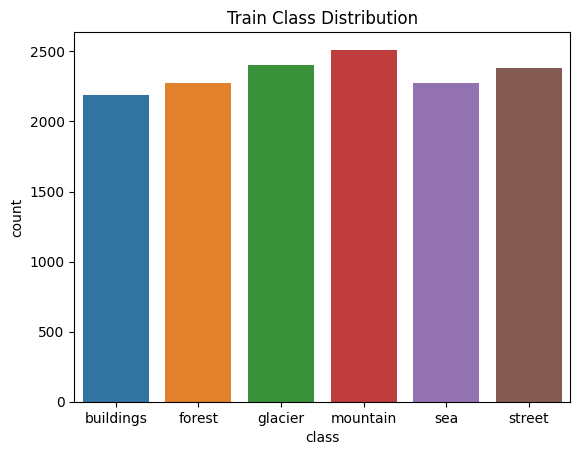

In [11]:
sns.countplot(x='class', data=train_df, order=sorted(train_df['class'].unique())).set(title='Train Class Distribution')

[Text(0.5, 1.0, 'Validation Class Distribution')]

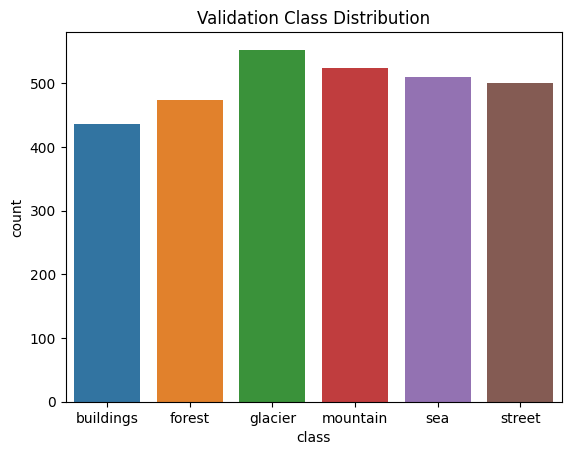

In [12]:
sns.countplot(x='class', data=val_df, order=sorted(val_df['class'].unique())).set(title='Validation Class Distribution')

[Text(0.5, 1.0, 'Test Class Distribution')]

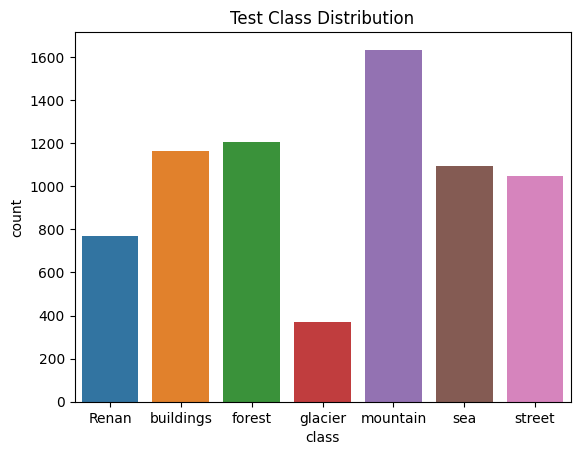

In [13]:
sns.countplot(x='class', data=test_df, order=sorted(test_df['class'].unique())).set(title='Test Class Distribution')

# 3. Preprocessing and Augmentation

In [14]:
class EnvironmentsDataset(Dataset):
  def __init__(self, df, transform=None, target_name='class', shuffle=True):
    begin_classes_idx = len(df.columns)

    self._data = self._shuffle(df) if shuffle else df
    self._transform = transform
    self._class_names = list(self.data[target_name].unique())

  @property
  def class_names(self):
    return self._class_names

  @property
  def data(self):
    return self._data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img = read_image(self._data.loc[idx, 'img'])
    label = self._class_names.index(self._data.loc[idx, 'class'])

    if self._transform:
      img = self._transform(img)

    return img, label

  def _apply_one_hot_encoding(self, df, target, shuffle=True):
    return pd.concat((df, pd.get_dummies(df[target])), axis=1)

  def _shuffle(self, df):
    return df.sample(frac=1).reset_index(drop=True)

In [15]:
# TODO: MELHORAR ESSE TRANSFORM?
transfs = transforms_v2.Compose([
    transforms.Resize(size=(224, 224), antialias=True),
    transforms_v2.RandomRotation(degrees=(-45, 45)),
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.ToDtype(torch.float32, scale=True),
    transforms_v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [16]:
train_dataset = EnvironmentsDataset(train_df, transform=transfs)
val_dataset = EnvironmentsDataset(val_df, transform=transfs)
test_dataset = EnvironmentsDataset(test_df, transform=transfs)

This is a buildings



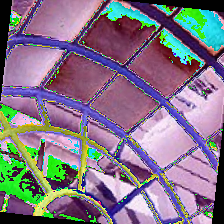

In [17]:
# Para visualizar a imagem normal, comente a ultima linha do Transformer Compose
print('This is a ' + train_dataset.class_names[train_dataset[0][1]], end='\n\n')
transforms.ToPILImage()(train_dataset[0][0])

# 4. Model Architecture and Training

In [38]:
BATCH_SIZE = 128
NUM_EPOCHS = 5

In [19]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
#test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
# input_layer = Input(shape=(150, 150, 3))

# # Convolutional layers
# conv1 = Conv2D(16, (3, 3), activation='relu')(input_layer)
# maxpool1 = MaxPooling2D((2, 2))(conv1)

# conv2 = Conv2D(32, (3, 3), activation='relu')(maxpool1)
# maxpool2 = MaxPooling2D((2, 2))(conv2)

# # Flatten and fully connected layers
# flatten = Flatten()(maxpool2)
# dense1 = Dense(128, activation='relu')(flatten)
# output_layer = Dense(6, activation='softmax')(dense1)
# model = Model(inputs=input_layer, outputs=output_layer)

In [21]:
# Mudar o tamanho da imagem e tentar a abordagem acima

class EnvClassificationNet(nn.Module):
  def __init__(self, num_classes):
    super(EnvClassificationNet, self).__init__()
    self.conv1 = nn.Conv2d(
        in_channels=3, out_channels=16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(
        in_channels=16, out_channels=16, kernel_size=3, padding=1)

    self.conv3 = nn.Conv2d(
        in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(
        in_channels=32, out_channels=32, kernel_size=3, padding=1)

    self.conv5 = nn.Conv2d(
        in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv6 = nn.Conv2d(
        in_channels=64, out_channels=64, kernel_size=3, padding=1)
    self.conv7 = nn.Conv2d(
        in_channels=64, out_channels=64, kernel_size=3, padding=1)

    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc14 = nn.Linear(64*28*28, 500)
    self.fc15 = nn.Linear(500, 50)

    self.out = nn.Linear(50, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))

    x = self.maxpool(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))

    x = self.maxpool(x)
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = F.relu(self.conv7(x))

    x = self.maxpool(x)

    x = x.reshape(x.shape[0], -1)
    x = F.relu(self.fc14(x))
    x = F.relu(self.fc15(x))
    x = F.dropout(x, 0.5)

    y_hat = self.out(x)
    return y_hat


In [ ]:
# Arquitetura alternativa

# model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2,2)))
# model.add(layers.Dropout(0.3))

# model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2,2)))
# model.add(layers.Dropout(0.5))

# model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2,2)))
# model.add(layers.Dropout(0.5))

# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(10, activation='softmax'))

In [61]:
def calc_val_loss(model, dataloader, loss_function):
  with torch.no_grad():
    total = .0
    for batch in dataloader:
      imgs, labels = batch

      imgs = imgs.to('cuda')
      labels = labels.to('cuda')

      total += loss_function(model(imgs), labels).item()

    return total / len(dataloader)

In [72]:
def format_time(seconds):
    if seconds < 60:
        return f'{seconds:.2f}s'
    else:
        m, s = divmod(seconds, 60)
        h, m = divmod(m, 60)

        if h <= 0:
            return f'{int(m)}m{s:.2f}s'
        else:
            return f'{h}h{int(m)}m{s:.2f}s'

In [82]:
import time
import math

def optimize(model, train_loader, val_loader, loss_func, optimizer, num_epochs, output_path):
  train_losses = []
  val_losses = []

  for epoch in range(1, num_epochs + 1):
    print(f'\nEpoch {epoch}/{num_epochs + 1}')
    start_time = time.time()
    total_time = 0

    total_loss = .0

    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        imgs, labels = batch

        imgs = imgs.to('cuda')
        labels = labels.to('cuda')

        loss = loss_func(model(imgs), labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        iteration_time = time.time() - start_time
        total_time += iteration_time

        avg_iteration_time = total_time / (i + 1)
        remaining_iterations = len(train_loader) - (i + 1)
        remaining_time = remaining_iterations * avg_iteration_time

        completion_percentage = (i + 1) / len(train_loader) * 100
        formatted_completion_percentage = math.floor(completion_percentage / 3.333)

        print(f'\r{i}/{len(train_loader)} [{"="*(formatted_completion_percentage)}{"."*(30 - formatted_completion_percentage)}] - {format_time(iteration_time)}/step - Loss: {loss:.6f} - {"Total Time" if i+1 == len(train_loader) else "ETA"}: {format_time(total_time) if i+1 == len(train_loader) else format_time(remaining_time)}', end='', flush=True)

    train_losses.append(total_loss / len(train_loader))
    val_losses.append(calc_val_loss(model, val_loader, loss_func))

  print('\nComplete! =)')
  torch.save(model.state_dict(), output_path)

  return train_losses, test_losses

In [62]:
model = EnvClassificationNet(len(train_dataset.class_names))

if torch.cuda.is_available():
  model.cuda()

In [63]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [83]:
train_losses, test_losses = optimize(model, train_loader, val_loader, loss_func, optimizer, NUM_EPOCHS, 'intel_classification_model.pth')


Epoch 1/6


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


3/110 [=.............................] - 6.74s/step - Loss: 0.639332 - ETA: 10m38.12s

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f677cbbb760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f677cbbb760>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f677cbbb760>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/pyt

109/110 [==============================] - 1m37.94s/step - Loss: 0.611538 - Total Time: 1.0h34m52.28s

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f677cbbb760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f677cbbb760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


Epoch 2/6


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f677cbbb760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f677cbbb760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

109/110 [==============================] - 1m34.53s/step - Loss: 0.728267 - Total Time: 1.0h32m2.68s
Epoch 3/6
109/110 [==============================] - 1m35.02s/step - Loss: 0.439969 - Total Time: 1.0h31m44.51s
Epoch 4/6
109/110 [==============================] - 1m36.08s/step - Loss: 0.560857 - Total Time: 1.0h32m44.39s
Epoch 5/6
109/110 [==============================] - 1m35.69s/step - Loss: 0.528394 - Total Time: 1.0h31m47.45sComplete! =)


NameError: ignored

# 5. Model Evaluation

In [84]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, marker='o', linestyle='-', color='b')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, marker='x', linestyle='-', color='g')

plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

NameError: ignored

<Figure size 800x500 with 0 Axes>